#### Loading libraries

In [9]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import time

#### >> Input Parameters

In [10]:
## Write the name of the manga in the same format as the default manga_name format 
## Whether it's JP or EN depends on the manga
manga_name = 'Shingeki+no+Kyojin'
## Exact total amount of chapters to-date (mandatory)
max_chapters = 139

#### Dataframe Definition

In [11]:
chapters_df = pd.DataFrame (columns = ['manga','chapter_num','link','total_number','mean','std'])

In [12]:
chapters_df.tail()

,manga,chapter_num,link,total_number,mean,std


#### Functions

In [13]:
def mal_chapter_finder_function(manga_dataframe, manga_name, max_chapters):
    
    ### MYANIMELIST SCRAP: Take a dataframe, but with established columns ###
    
    headers = {"User-Agent": "Mozilla/5.0"}
    cookies = {"CONSENT": "YES+cb.20210721-07-p0.en+FX+410"}
    ## Get all the possible urls
    urls = []
    for i in range(1, max_chapters+1):
        urls.append("https://myanimelist.net/forum/search?cat=forum&q="+manga_name+"+Chapter+"+str(i)+"+Discussion&u=&uloc=1&loc=-1")
    
    ## Go through all the possible urls
    for i in urls:
        page = requests.get(i, cookies=cookies, headers=headers)
        soup = BeautifulSoup(page.content,'html.parser') 
        
        list_link = []
        for k in soup.find_all('td', {'class': 'forum_boardrow1'}):
            if k.find(text=re.compile("Poll:")): ## making sure that you only take the poll threads
                link = k.find('a', href=True)
                list_link.append([link['href'], link.text])

        ## Keeping only chapter links
        list_link = [j for j in list_link if '?topicid=' in j[0]]
        
        ## Adding the poll results string to the links and cheking if it's in the df to include or not
        for k in list_link:
            k[0] = k[0]+'&pollresults=1'
            if [k][0][0] not in list(manga_dataframe['link']):
                manga_dataframe.loc[len(manga_dataframe)+1] = [manga_name, re.findall(r'\d+', [k][0][1])[0], [k][0][0], np.NaN, np.NaN, np.NaN] ## adding chapter link and extracting the chapter number as well      
    
    return(manga_dataframe)
    
    ### Return a dataframe with all the available chapters: Will fill the manga name, chapter_num, link ###

In [14]:
def google_chapter_finder_function(manga_dataframe, manga_name, max_chapters):
    
    ### GOOGLE SCRAP: Take a dataframe, but with established columns ###
    ## Gives more results because google's search engine is more powerful than mal seach engine
    ## Possible errors might occur if google blocks traffic
    
    chapters = [str(i) for i in range(1, max_chapters+1)] ## all the available chapters in a string format
    headers = {"User-Agent": "Mozilla/5.0"}
    cookies = {"CONSENT": "YES+cb.20210721-07-p0.en+FX+410"}
    
    for i in chapters:
        if i not in list(manga_dataframe['chapter_num']):
            url = 'https://www.google.com/search?q='+manga_name+'+Chapter+'+i+'+Discussion+site:myanimelist.net'
            time.sleep(2) # sleeping to avoid google's scraping restrictions
            page = requests.get(url, cookies=cookies, headers=headers)                  
            soup = BeautifulSoup(page.content, "html5lib")
            links = soup.findAll("a")
            temp_google_links = []
            for link in links :
                link_href = link.get('href')
                if "url?q=" in link_href and not "webcache" in link_href:
                    temp_google_links.append((link.get('href').split("?q=")[1].split("&sa=U")[0]))      
            manga_dataframe.loc[len(manga_dataframe)+1] = [manga_name, i, "https://myanimelist.net/forum/?topicid="+temp_google_links[0].split("topicid%3D",1)[1]+"&pollresults=1", np.NaN, np.NaN, np.NaN] ## adding chapter link and extracting the chapter number as well
    return(manga_dataframe)

In [15]:
## A function that returns the total number of voters
def chapter_rating_total_number_function(link):
    dfs = pd.read_html(link)
    total = np.sum(dfs[0][2])
    return(total)

## A function that returns the mean of the chapters
def chapter_rating_mean_function(link):
    dfs = pd.read_html(link)
    dfs[0][2] = dfs[0][2].replace(np.nan, 0) ## change null values to 0 before calculations
    dfs[0][2] = dfs[0][2].astype(np.int64) ## need to convert to int to do calculation below with 1d array
    mean = np.mean([1]*dfs[0][2][4] + [2]*dfs[0][2][3] + [3]*dfs[0][2][2] + [4]*dfs[0][2][1] + [5]*dfs[0][2][0])
    return(round(mean,2))

## A function that returns the std of the chapters
def chapter_rating_std_function(link):
    dfs = pd.read_html(link)
    dfs[0][2] = dfs[0][2].replace(np.nan, 0) ## change null values to 0 before calculations
    dfs[0][2] = dfs[0][2].astype(np.int64) ## need to convert to int to do calculation below with 1d array
    std = np.std([1]*dfs[0][2][4] + [2]*dfs[0][2][3] + [3]*dfs[0][2][2] + [4]*dfs[0][2][1] + [5]*dfs[0][2][0])
    return(round(std,2))

#### Reading the poll results - Calculation & Insertion

In [16]:
mal_chapter_finder_function(chapters_df, manga_name, max_chapters)

,manga,chapter_num,link,total_number,mean,std
1,Shingeki+no+Kyojin,3,https://myanimelist.net/forum/?topicid=361329&...,NaN,NaN,NaN
2,Shingeki+no+Kyojin,138,https://myanimelist.net/forum/?topicid=1903003...,NaN,NaN,NaN
3,Shingeki+no+Kyojin,120,https://myanimelist.net/forum/?topicid=1795908...,NaN,NaN,NaN
4,Shingeki+no+Kyojin,130,https://myanimelist.net/forum/?topicid=1850517...,NaN,NaN,NaN
5,Shingeki+no+Kyojin,111,https://myanimelist.net/forum/?topicid=1750197...,NaN,NaN,NaN
...,...,...,...,...,...,...
75,Shingeki+no+Kyojin,132,https://myanimelist.net/forum/?topicid=1863324...,NaN,NaN,NaN
76,Shingeki+no+Kyojin,133,https://myanimelist.net/forum/?topicid=1868562...,NaN,NaN,NaN
77,Shingeki+no+Kyojin,134,https://myanimelist.net/forum/?topicid=1874352...,NaN,NaN,NaN
78,Shingeki+no+Kyojin,136,https://myanimelist.net/forum/?topicid=1887171...,NaN,NaN,NaN


In [17]:
chapters_df.tail()

,manga,chapter_num,link,total_number,mean,std
75,Shingeki+no+Kyojin,132,https://myanimelist.net/forum/?topicid=1863324...,NaN,NaN,NaN
76,Shingeki+no+Kyojin,133,https://myanimelist.net/forum/?topicid=1868562...,NaN,NaN,NaN
77,Shingeki+no+Kyojin,134,https://myanimelist.net/forum/?topicid=1874352...,NaN,NaN,NaN
78,Shingeki+no+Kyojin,136,https://myanimelist.net/forum/?topicid=1887171...,NaN,NaN,NaN
79,Shingeki+no+Kyojin,137,https://myanimelist.net/forum/?topicid=1895862...,NaN,NaN,NaN


In [18]:
google_chapter_finder_function(chapters_df, manga_name, max_chapters)

,manga,chapter_num,link,total_number,mean,std
1,Shingeki+no+Kyojin,3,https://myanimelist.net/forum/?topicid=361329&...,NaN,NaN,NaN
2,Shingeki+no+Kyojin,138,https://myanimelist.net/forum/?topicid=1903003...,NaN,NaN,NaN
3,Shingeki+no+Kyojin,120,https://myanimelist.net/forum/?topicid=1795908...,NaN,NaN,NaN
4,Shingeki+no+Kyojin,130,https://myanimelist.net/forum/?topicid=1850517...,NaN,NaN,NaN
5,Shingeki+no+Kyojin,111,https://myanimelist.net/forum/?topicid=1750197...,NaN,NaN,NaN
...,...,...,...,...,...,...
135,Shingeki+no+Kyojin,94,https://myanimelist.net/forum/?topicid=1623533...,NaN,NaN,NaN
136,Shingeki+no+Kyojin,95,https://myanimelist.net/forum/?topicid=1634116...,NaN,NaN,NaN
137,Shingeki+no+Kyojin,96,https://myanimelist.net/forum/?topicid=1645414...,NaN,NaN,NaN
138,Shingeki+no+Kyojin,98,https://myanimelist.net/forum/?topicid=1670692...,NaN,NaN,NaN


In [19]:
print(chapters_df.tail())
chapters_df_temp = chapters_df.copy()

                  manga chapter_num  \
135  Shingeki+no+Kyojin          94   
136  Shingeki+no+Kyojin          95   
137  Shingeki+no+Kyojin          96   
138  Shingeki+no+Kyojin          98   
139  Shingeki+no+Kyojin         139   

                                                  link total_number mean  std  
135  https://myanimelist.net/forum/?topicid=1623533...          NaN  NaN  NaN  
136  https://myanimelist.net/forum/?topicid=1634116...          NaN  NaN  NaN  
137  https://myanimelist.net/forum/?topicid=1645414...          NaN  NaN  NaN  
138  https://myanimelist.net/forum/?topicid=1670692...          NaN  NaN  NaN  
139  https://myanimelist.net/forum/?topicid=1912863...          NaN  NaN  NaN  


In [20]:
## time.sleep is used for break to avoid server restrictions
time.sleep(240)

In [21]:
## Total, mean, std: 3 separate for loops to avoid server restrictions
## temporary for i in range(1,len(chapters_df)-1): instead of chapters_df.index
## Also seperate the functions for avoiding HMTL errors
for i in range(0,len(chapters_df)):
    chapters_df.iloc[i,3] = chapter_rating_total_number_function(chapters_df.iloc[i,2])

In [22]:
time.sleep(240)

In [23]:
for i in range(0,len(chapters_df)):
    chapters_df.iloc[i,4] = chapter_rating_mean_function(chapters_df.iloc[i,2])

In [24]:
time.sleep(240)

In [25]:
for i in range(0,len(chapters_df)):
    chapters_df.iloc[i,5] = chapter_rating_std_function(chapters_df.iloc[i,2])

#### Quick clean

In [26]:
# Transform chapter number to int for order
chapters_df['chapter_num'] = chapters_df['chapter_num'].astype(np.int64)
# Order dataframe by chapter number
chapters_df = chapters_df.sort_values('chapter_num')

In [27]:
chapters_df

,manga,chapter_num,link,total_number,mean,std
80,Shingeki+no+Kyojin,1,https://myanimelist.net/forum/?topicid=279049&...,159,4.64,0.67
27,Shingeki+no+Kyojin,2,https://myanimelist.net/forum/?topicid=361327&...,70,4.66,0.61
1,Shingeki+no+Kyojin,3,https://myanimelist.net/forum/?topicid=361329&...,66,4.58,0.63
22,Shingeki+no+Kyojin,4,https://myanimelist.net/forum/?topicid=325169&...,79,4.81,0.53
81,Shingeki+no+Kyojin,5,https://myanimelist.net/forum/?topicid=498181&...,65,4.8,0.4
...,...,...,...,...,...,...
6,Shingeki+no+Kyojin,135,https://myanimelist.net/forum/?topicid=1879687...,579,4.31,1.09
78,Shingeki+no+Kyojin,136,https://myanimelist.net/forum/?topicid=1887171...,657,4.32,1.14
79,Shingeki+no+Kyojin,137,https://myanimelist.net/forum/?topicid=1895862...,1611,3.55,1.55
2,Shingeki+no+Kyojin,138,https://myanimelist.net/forum/?topicid=1903003...,2167,3.82,1.52


#### CSV Export

In [28]:
# chapters_df.to_csv('mal_export.csv')

#### Quick Visualizations

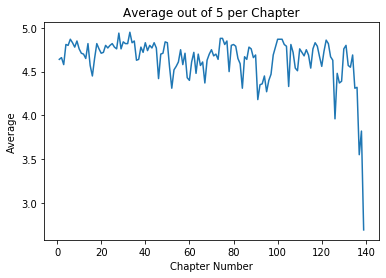

In [29]:
x = chapters_df['chapter_num']
y = chapters_df['mean']
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set(title = 'Average out of 5 per Chapter',
       xlabel = 'Chapter Number',
       ylabel = 'Average')
ax.plot(x,y)
plt.show()

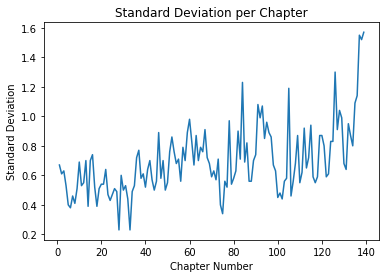

In [30]:
x = chapters_df['chapter_num']
y = chapters_df['std']
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set(title = 'Standard Deviation per Chapter',
       xlabel = 'Chapter Number',
       ylabel = 'Standard Deviation')
ax.plot(x,y)
plt.show()

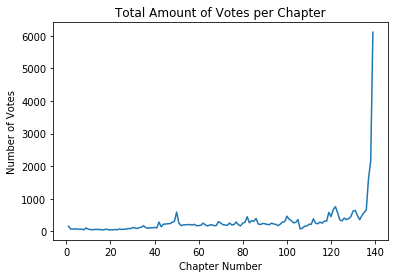

In [31]:
x = chapters_df['chapter_num']
y = chapters_df['total_number']
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set(title = 'Total Amount of Votes per Chapter',
       xlabel = 'Chapter Number',
       ylabel = 'Number of Votes')
ax.plot(x,y)
plt.show()